In [1]:
#Transfer leraning with Tensorfow part 3 : Scaling up
!nvidia-smi

Wed Feb 28 23:17:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0              18W /  80W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# creating helper functions
from extras.helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir,compare_historys,make_confusion_matrix

In [3]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [4]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [5]:
#Setup Data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,label_mode="categorical",image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,label_mode="categorical",image_size=IMG_SIZE,shuffle=False) # dont shuffle test data

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
#create checkpoint callback
checkpoint_path = "transfer_learning/101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,)

In [7]:
#create data augmentation layer to incorporate it into model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


#setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1/255.) #Rescale input of images between 0 & 1 , required for model like resnet50
] ,name = "data_augmentation")

In [8]:
# setup the base model and freeze its layers
#005 Creating a headless EfficientNetB0 model with data augmentation built in
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable=False

#Setup model architecuture with trainable top layers
inputs = layers.Input(shape=(224,224,3),name="input_layer")
x= data_augmentation(inputs) #augment images (only happens during training phase
x = base_model(x,training=False) # put the base model in inference mode so weights are frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x) # in case of models (like sequential) input go inside model in layers inputs go outside model
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

In [9]:
# get summary of model created
model.summary() # transfer learning feature extraction model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [10]:
#006 Fitting and evaluating our biggest transfer learning model yet
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 89s 338ms/step - loss: 3.5385 - accuracy: 0.2395 - val_loss: 2.6954 - val_accuracy: 0.4002
Epoch 2/5
237/237 [==============================] - 77s 326ms/step - loss: 2.4286 - accuracy: 0.4458 - val_loss: 2.2602 - val_accuracy: 0.4568
Epoch 3/5
237/237 [==============================] - 76s 319ms/step - loss: 2.0550 - accuracy: 0.5109 - val_loss: 2.0463 - val_accuracy: 0.4857
Epoch 4/5
237/237 [==============================] - 75s 316ms/step - loss: 1.8344 - accuracy: 0.5562 - val_loss: 1.9463 - val_accuracy: 0.5058
Epoch 5/5
237/237 [==============================] - 73s 306ms/step - loss: 1.6936 - accuracy: 0.5847 - val_loss: 1.8365 - val_accuracy: 0.5339


In [11]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 57s 72ms/step - loss: 1.6370 - accuracy: 0.5689


[1.6369937658309937, 0.568871259689331]

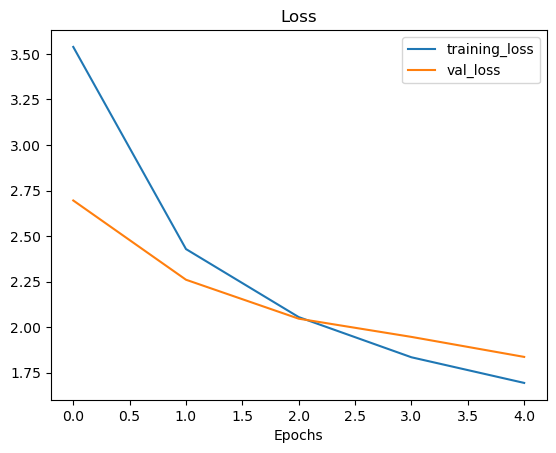

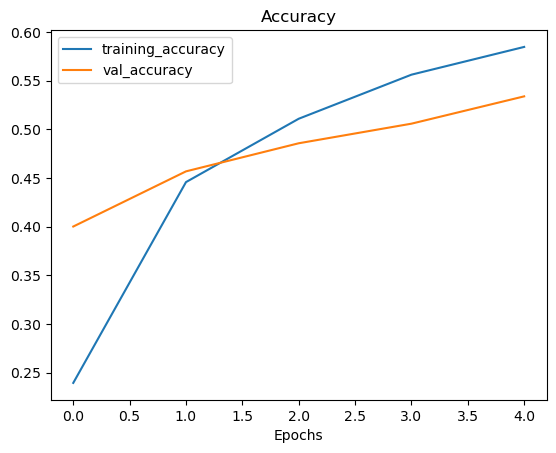

In [12]:
plot_loss_curves(history_all_classes_10_percent)

In [13]:
#007 Unfreezing some layers in our base model to prepare for fine-tuning
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last file
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [14]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [15]:
#008 Fine-tuning our feature extraction model and evaluating its performance
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 82s 316ms/step - loss: 1.5033 - accuracy: 0.6252 - val_loss: 1.7921 - val_accuracy: 0.5326
Epoch 6/10
237/237 [==============================] - 72s 303ms/step - loss: 1.3947 - accuracy: 0.6425 - val_loss: 1.7939 - val_accuracy: 0.5297
Epoch 7/10
237/237 [==============================] - 70s 293ms/step - loss: 1.3355 - accuracy: 0.6507 - val_loss: 1.8079 - val_accuracy: 0.5278
Epoch 8/10
237/237 [==============================] - 70s 295ms/step - loss: 1.2895 - accuracy: 0.6657 - val_loss: 1.7808 - val_accuracy: 0.5363
Epoch 9/10
237/237 [==============================] - 73s 306ms/step - loss: 1.2570 - accuracy: 0.6652 - val_loss: 1.7635 - val_accuracy: 0.5429
Epoch 10/10
237/237 [==============================] - 71s 298ms/step - loss: 1.2113 - accuracy: 0.6785 - val_loss: 1.7575 - val_accuracy: 0.5429


In [16]:
all_classes_10_percent_fine_tuning_results = model.evaluate(test_data)
all_classes_10_percent_fine_tuning_results

790/790 [==============================] - 58s 73ms/step - loss: 1.4955 - accuracy: 0.6001


[1.4954612255096436, 0.6001188158988953]

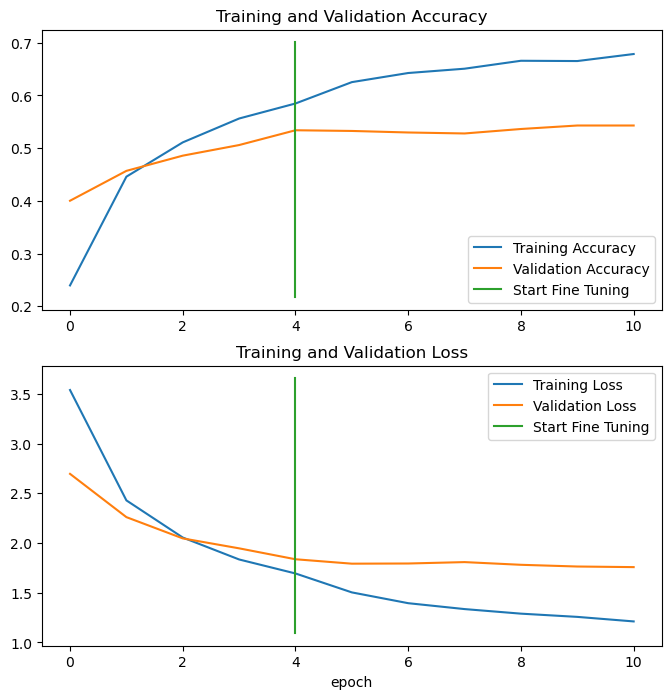

In [17]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [18]:
#009 Saving and loading our trained model
#Saving and loading our model
#model.save("saved_models/101_food_classes_10_percent")
#model.save("saved_models/101_food_classes_10_percent")

In [19]:
loaded_model = tf.keras.models.load_model("saved_models/101_food_classes_10_percent")

In [20]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 61s 75ms/step - loss: 1.5043 - accuracy: 0.5981


[1.5042568445205688, 0.5980989933013916]

In [21]:
#010 Downloading a pretrained model to make and evaluate predictions with
#Evaluating performance of the big model across all different classes
model = tf.keras.models.load_model("saved_models/06_101_food_class_10_percent_saved_big_dog_model")

import tensorflow as tf

In [22]:
#evaluate the downloaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 64s 79ms/step - loss: 1.8019 - accuracy: 0.6077


[1.8019390106201172, 0.6077227592468262]

In [23]:
#011 Making predictions with our trained model on 25,250 test samples

In [24]:
#Making predictions with our trained models
preds_probs = model.predict(test_data,verbose=1)

790/790 [==============================] - 63s 78ms/step


In [25]:
preds_probs.shape

(25250, 101)

In [26]:
# getting the pred classes of each labels
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0], dtype=int64)

In [27]:
#012 Unravelling our test dataset for comparing ground truth labels to predictions
# Unbatch the dataset test_data
y_labels = []
for images,labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())

y_labels[:10]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [28]:
#013 Confirming our model's predictions are in the same order as the test labels
results_downloaded_model

[1.8019390106201172, 0.6077227592468262]

In [29]:
#using sklearn accuracy score function
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077227722772277

In [30]:
import numpy as np
np.isclose(results_downloaded_model[1],sklearn_accuracy)

True

In [31]:
#014 Creating a confusion matrix for our model's 101 different classes
#get a list of class names
class_names = test_data.class_names
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

In [32]:
#015 Evaluating every individual class in our dataset
#Sklearn has a helpful funtion for diff classification metrics
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.35      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.83      0.48      0.61       250
          12       0.53      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [33]:
#get a dict of the classification report
classification_repot_dict = classification_report(y_true=y_labels,y_pred=pred_classes,output_dict=True)
classification_repot_dict
# support is number of samples

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5605536332179931,
  'recall': 0.648,
  'f1-score': 0.601113172541744,
  'support': 250.0},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250.0},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250.0},
 '5': {'precision': 0.3452685421994885,
  'recall': 0.54,
  'f1-score': 0.42121684867394693,
  'support': 250.0},
 '6': {'precision': 0.6700680272108843,
  'recall': 0.788,
  'f1-score': 0.724264705882353,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.386694386694386

In [34]:
class_f1_scores = {}
for k,v in classification_repot_dict.items():
    if k == "accuracy" : # stop once we get to accuracy key
        break
    else:
        class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.601113172541744,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.42121684867394693,
 'beignets': 0.724264705882353,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6126582278481012,
 'cannoli': 0.6146179401993355,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.37122969837587005,
 'cheese_plate': 0.5662650602409639,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7074569789674952,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.32499999999999996,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.7325102880658436,
 'crab_cakes': 0.46153846153846156,
 'creme_brule

In [35]:
# sort dict
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1-scores":list(class_f1_scores.values())}).sort_values('f1-scores',ascending=False)

In [36]:
f1_scores

class_names  f1-scores
33              edamame   0.935361
63             macarons   0.897275
75                  pho   0.869903
91  spaghetti_carbonara   0.847656
69              oysters   0.834008
..                  ...        ...
56     huevos_rancheros   0.335196
22     chocolate_mousse   0.325000
77            pork_chop   0.304850
39            foie_gras   0.296429
0             apple_pie   0.240566

[101 rows x 2 columns]

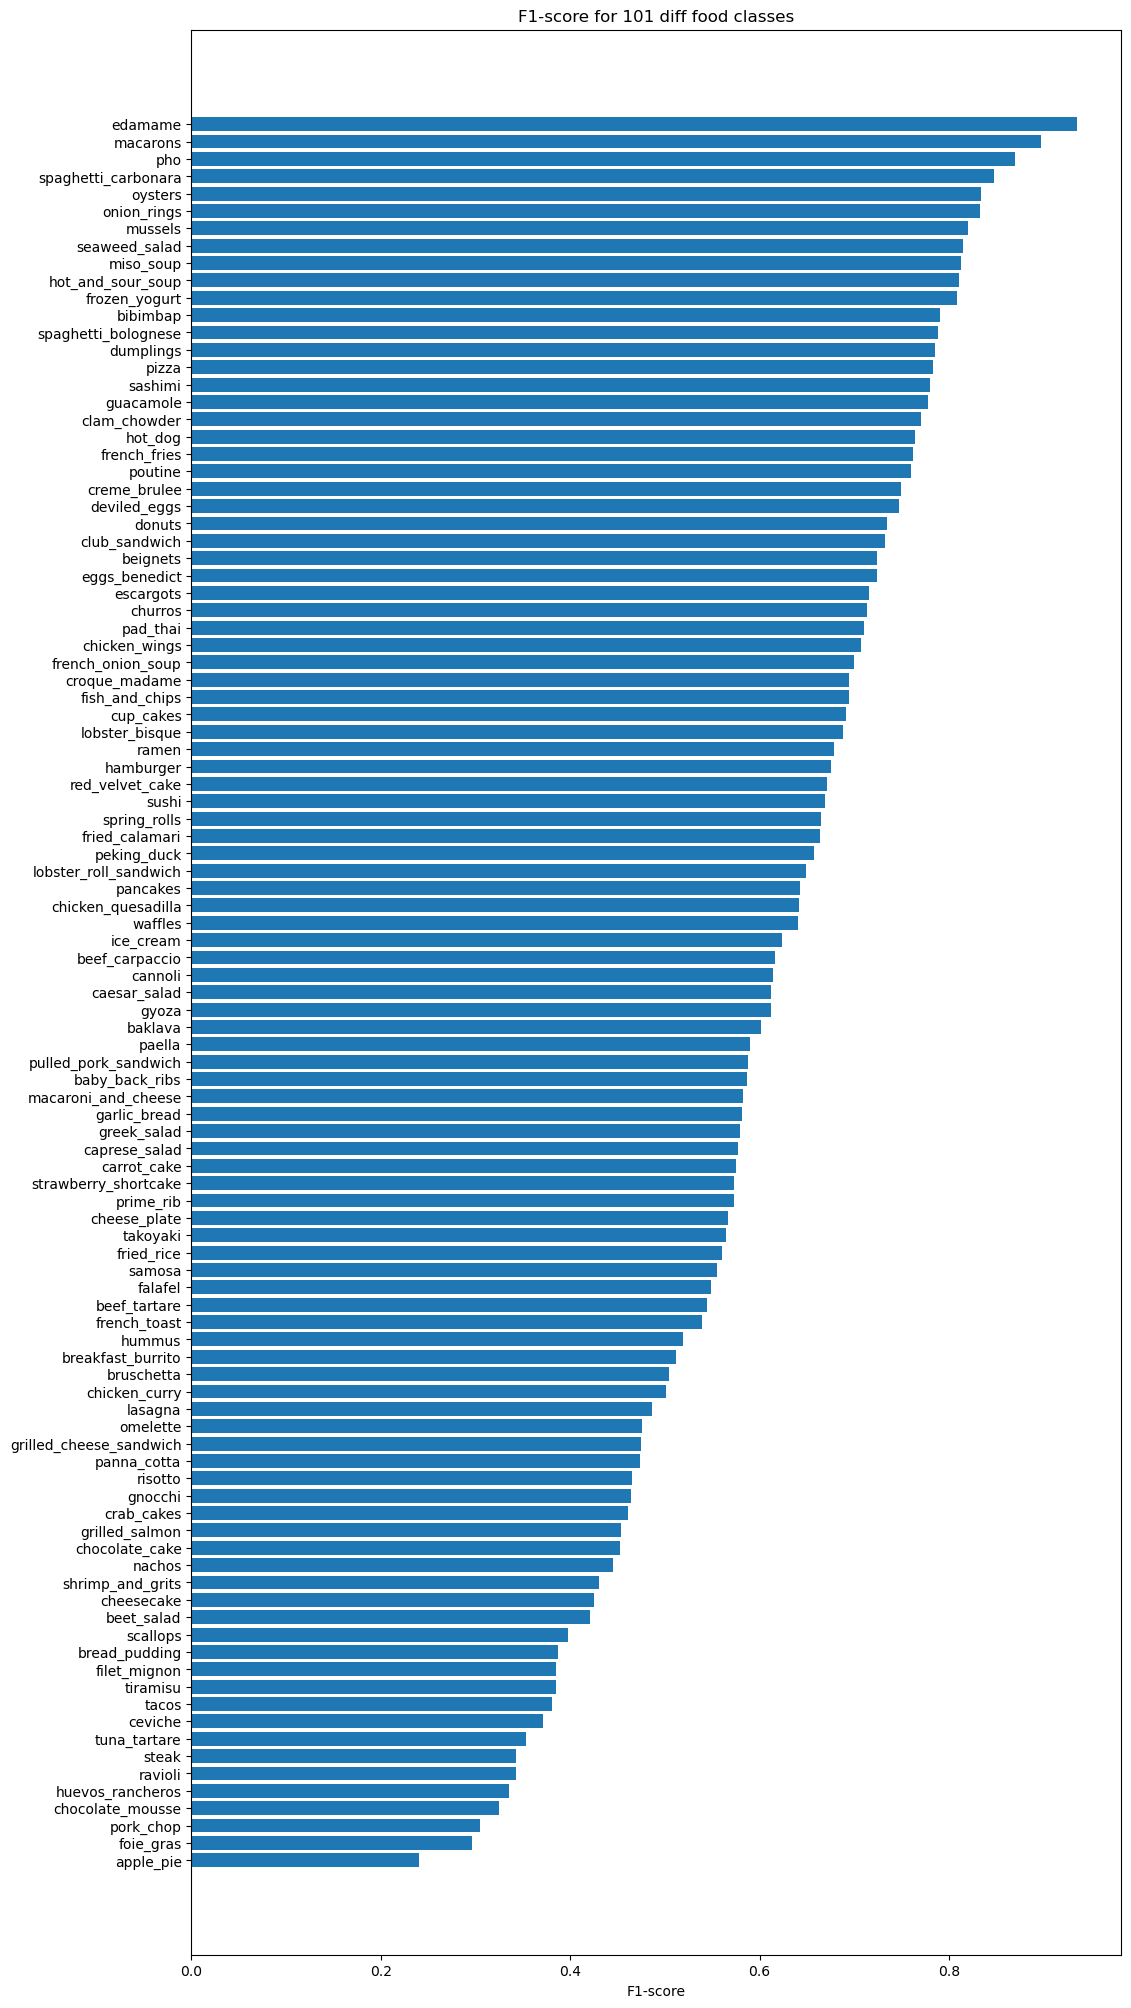

In [37]:
#016 Plotting our model's F1-scores for each separate class
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12,25))
scores = ax.barh(range(len(f1_scores)),f1_scores["f1-scores"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 101 diff food classes")
ax.invert_yaxis()

In [38]:
#017 Creating a function to load and prepare images for making predictions
# to visualize model predictions - function
def load_and_prep_image(filename,img_shape = 224,scale=True):
    img = tf.io.read_file(filename)
    img = tf.io.decode_image(img,channels=3)
    img = tf.image.resize(img,[img_shape,img_shape])
    if scale:
        return img/255.
    else:
        return img

1/1 [==============================] - 0s 26ms/step


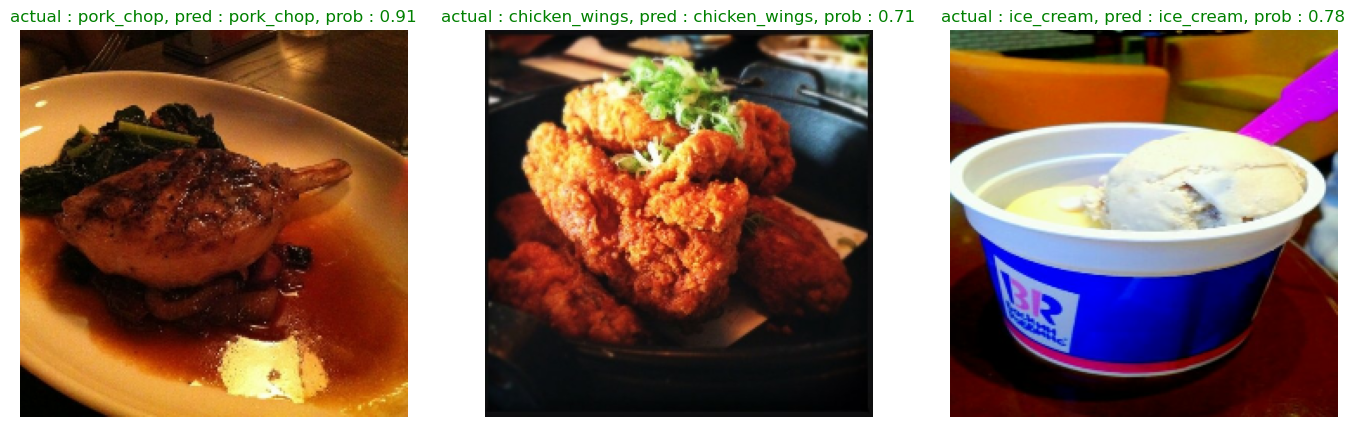

In [62]:
#018 Making predictions on our test images and evaluating them
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/"+class_name))
    filepath = test_dir + class_name+"/"+filename

    img = load_and_prep_image(filepath,scale=False)
    pred_prob = model.predict(tf.expand_dims(img,axis=0))
    pred_class = class_names[pred_prob.argmax()]

    plt.subplot(1,3,i+1)
    plt.imshow(img/255.)
    if class_name == pred_class:
        title_color = "g"
    else:
        title_color = "r"

    plt.title(f"actual : {class_name}, pred : {pred_class}, prob : {pred_prob.max():.2f}",c=title_color)
    plt.axis(False)
plt.show()

In [78]:
#019 Discussing the benefits of finding your model's most wrong predictions
#020 Writing code to uncover our model's most wrong predictions
filepaths = []
for filepath in test_data.list_files("E:/Tensorflow/tensorflow/TransferLearning/101_food_classes_10_percent/test/*/*.jpg",shuffle=False):

    filepaths.append(filepath.numpy())

filepaths


[b'E:\\Tensorflow\\tensorflow\\TransferLearning\\101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'E:\\Tensorflow\\tensorflow\\TransferLearning\\101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'E:\\Tensorflow\\tensorflow\\TransferLearning\\101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'E:\\Tensorflow\\tensorflow\\TransferLearning\\101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'E:\\Tensorflow\\tensorflow\\TransferLearning\\101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'E:\\Tensorflow\\tensorflow\\TransferLearning\\101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'E:\\Tensorflow\\tensorflow\\TransferLearning\\101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'E:\\Tensorflow\\tensorflow\\TransferLearning\\101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'E:\\Tensorflow\\tensorflow\\TransferLearning\\101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'E:\\Tensorflow\\ten

In [80]:
import pandas as pd
pred_df = pd.DataFrame({"img_path":filepaths,
                        "y_true":y_labels,
                        "y_pred":pred_classes,
"pred_conf":preds_probs.max(axis=1),
                         "y_true_classname":[class_names[i] for i in y_labels],
                        "y_pred_classname":[class_names[i] for i in pred_classes]
                       })
pred_df

img_path  y_true  y_pred  \
0      b'E:\\Tensorflow\\tensorflow\\TransferLearning...       0      52   
1      b'E:\\Tensorflow\\tensorflow\\TransferLearning...       0       0   
2      b'E:\\Tensorflow\\tensorflow\\TransferLearning...       0       0   
3      b'E:\\Tensorflow\\tensorflow\\TransferLearning...       0      80   
4      b'E:\\Tensorflow\\tensorflow\\TransferLearning...       0      79   
...                                                  ...     ...     ...   
25245  b'E:\\Tensorflow\\tensorflow\\TransferLearning...     100     100   
25246  b'E:\\Tensorflow\\tensorflow\\TransferLearning...     100      16   
25247  b'E:\\Tensorflow\\tensorflow\\TransferLearning...     100     100   
25248  b'E:\\Tensorflow\\tensorflow\\TransferLearning...     100      94   
25249  b'E:\\Tensorflow\\tensorflow\\TransferLearning...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.846994        apple_pie                 gyoza  
1       0.963172        apple_pie             apple_pie  
2       0.959345        apple_pie             apple_pie  
3       0.656389        apple_pie  pulled_pork_sandwich  
4       0.358391        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972810          waffles               waffles  
25246   0.880657          waffles          cheese_plate  
25247   0.539691          waffles               waffles  
25248   0.504665          waffles  strawberry_shortcake  
25249   0.689928          waffles               waffles  

[25250 rows x 6 columns]

In [81]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

In [82]:
pred_df

img_path  y_true  y_pred  \
0      b'E:\\Tensorflow\\tensorflow\\TransferLearning...       0      52   
1      b'E:\\Tensorflow\\tensorflow\\TransferLearning...       0       0   
2      b'E:\\Tensorflow\\tensorflow\\TransferLearning...       0       0   
3      b'E:\\Tensorflow\\tensorflow\\TransferLearning...       0      80   
4      b'E:\\Tensorflow\\tensorflow\\TransferLearning...       0      79   
...                                                  ...     ...     ...   
25245  b'E:\\Tensorflow\\tensorflow\\TransferLearning...     100     100   
25246  b'E:\\Tensorflow\\tensorflow\\TransferLearning...     100      16   
25247  b'E:\\Tensorflow\\tensorflow\\TransferLearning...     100     100   
25248  b'E:\\Tensorflow\\tensorflow\\TransferLearning...     100      94   
25249  b'E:\\Tensorflow\\tensorflow\\TransferLearning...     100     100   

       pred_conf y_true_classname      y_pred_classname  pred_correct  
0       0.846994        apple_pie                 gyoza         False  
1       0.963172        apple_pie             apple_pie          True  
2       0.959345        apple_pie             apple_pie          True  
3       0.656389        apple_pie  pulled_pork_sandwich         False  
4       0.358391        apple_pie             prime_rib         False  
...          ...              ...                   ...           ...  
25245   0.972810          waffles               waffles          True  
25246   0.880657          waffles          cheese_plate         False  
25247   0.539691          waffles               waffles          True  
25248   0.504665          waffles  strawberry_shortcake         False  
25249   0.689928          waffles               waffles          True  

[25250 rows x 7 columns]

In [83]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf",ascending=False)[:100]

In [84]:
top_100_wrong

img_path  y_true  y_pred  \
21810  b'E:\\Tensorflow\\tensorflow\\TransferLearning...      87      29   
231    b'E:\\Tensorflow\\tensorflow\\TransferLearning...       0     100   
15359  b'E:\\Tensorflow\\tensorflow\\TransferLearning...      61      53   
23539  b'E:\\Tensorflow\\tensorflow\\TransferLearning...      94      83   
21400  b'E:\\Tensorflow\\tensorflow\\TransferLearning...      85      92   
...                                                  ...     ...     ...   
8763   b'E:\\Tensorflow\\tensorflow\\TransferLearning...      35      41   
7924   b'E:\\Tensorflow\\tensorflow\\TransferLearning...      31      29   
2663   b'E:\\Tensorflow\\tensorflow\\TransferLearning...      10      61   
18586  b'E:\\Tensorflow\\tensorflow\\TransferLearning...      74      39   
3519   b'E:\\Tensorflow\\tensorflow\\TransferLearning...      14      21   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999982                 samosa           spring_rolls         False  
...          ...                    ...                    ...           ...  
8763    0.997178              escargots      french_onion_soup         False  
7924    0.997072                 donuts              cup_cakes         False  
2663    0.997069             bruschetta  lobster_roll_sandwich         False  
18586   0.996874            peking_duck              foie_gras         False  
3519    0.996865            carrot_cake         chocolate_cake         False  

[100 rows x 7 columns]

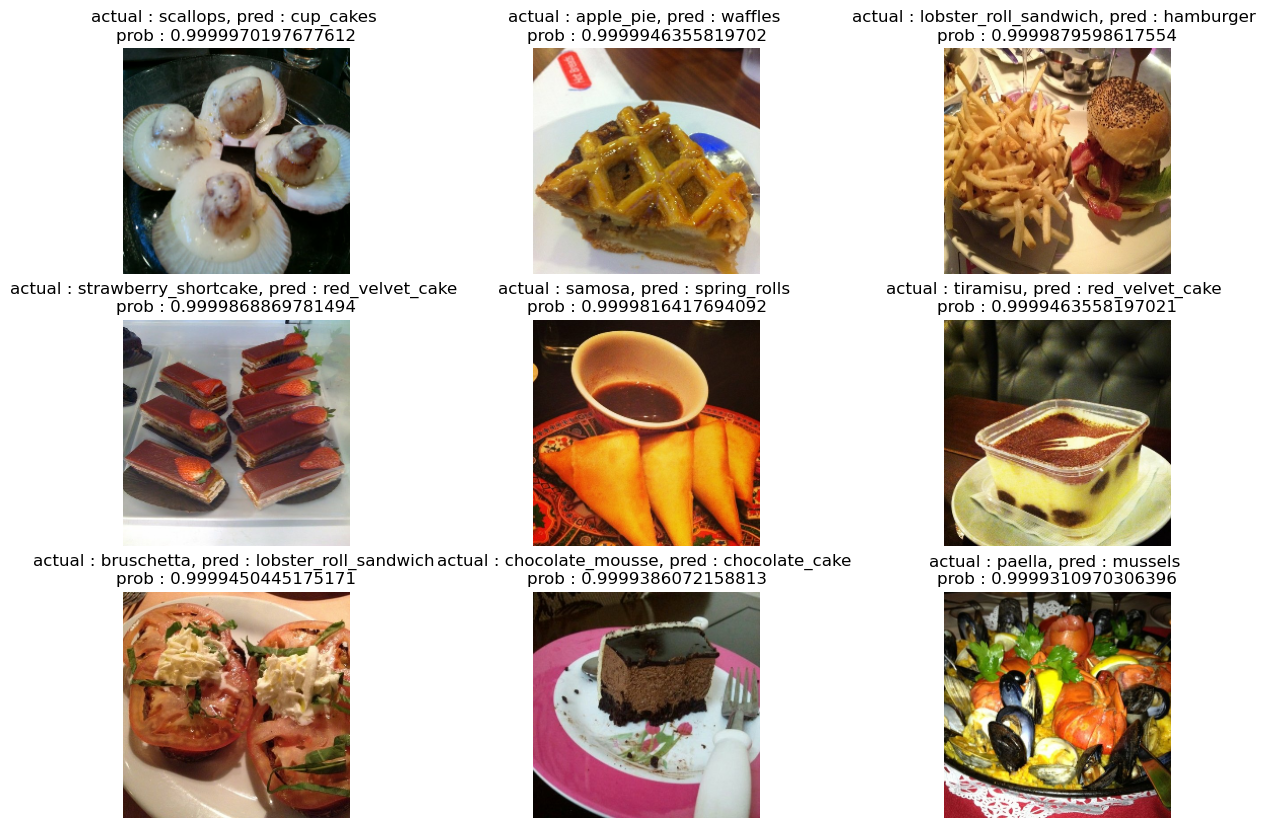

In [93]:
#021 Plotting and visualising the samples our model got most wrong
images_to_view = 9
start_index = 0
plt.figure(figsize=(15,10))
for i , row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3,3,i+1)
    img = load_and_prep_image(row[1],scale=False)
    _,_,_,_,pred_prob,y_true_classname,y_pred_classname,_= row
    plt.imshow(img/255.)
    plt.title(f"actual : {y_true_classname}, pred : {y_pred_classname} \nprob : {pred_prob}")
    plt.axis(False)
plt.show()


In [ ]:
#022 Making predictions on and plotting our own custom images
